# Aug 11th, 2022 (render + ROI presence)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
fig_dir = pjoin(fig_base_dir, 'paper2.0', 'Render')
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

merge_thres = {
    128: 0.376,
    512: 0.444,
}
kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/Render

## Prepare (512)

In [3]:
nn = 512
mice = Mice(nn)
# *_, props_ca = default_props(mice)
# bt = BootStrap(**props_ca)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

## ROI presence freq

In [4]:
from register.register import Register

reg = Register(mice)
reg.set_mode('ca2')

In [5]:
output = reg.get_accepted_regions()
freq = output['cortex']['freq']

Name: cortex . . . a total of: 542 regions accepted, 172 regions rejected.
accept ratio: 75.91 %, reject ratio: 24.09 %, using a presence threshold of 20.0 %

In [6]:
top, flat = bt.load_top_flat()
parcel_top, parcel_flat = mice.parcel.load_top_flat()

In [7]:
freq_ctx = np.zeros(top.shape, dtype=float)
for r, f in freq.items():
    m = parcel_top == r
    if not m.sum():
        continue
    freq_ctx[m] = f
    
freq_ctx *= 100

In [8]:
f_tr, t_tr = filter_boundaries([freq_ctx, top], top.astype(bool))

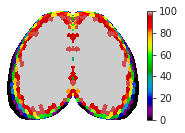

In [11]:
fig, ax = create_figure(figsize=(3, 2))
cmap = 'nipy_spectral'

x2p = np.ma.masked_where(t_tr == 0, t_tr)
plt.imshow(x2p)

x2p = np.ma.masked_where(t_tr == 0, f_tr)
plt.imshow(x2p, cmap=cmap)
plt.colorbar()

remove_ticks(ax)

name = f'coverage-top'
figname = f"{name}.pdf"
fig.savefig(pjoin(fig_dir, figname), bbox_inches='tight')
for dpi in [100, 300, 600]:
    figname = f"{name}_dpi{dpi}.png"
    fig.savefig(pjoin(fig_dir, figname), dpi=dpi, bbox_inches='tight', transparent=True)

plt.show()

## Render

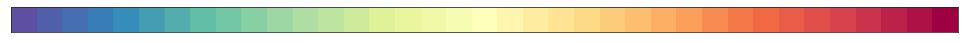

In [19]:
sys.path.insert(0, pjoin(git_dir, 'vedo'))
sys.path.insert(0, pjoin(git_dir, 'brainrender'))

from bg_space import AnatomicalSpace

from brainrender import Scene
from brainrender import settings as br_settings
from brainrender.actors.streamlines import make_streamlines
from brainrender.atlas_specific import get_streamlines_for_region

from vedo import Volume as vd_Volume
from register.atlas import load_bg_atlas

cmap = sns.color_palette('Spectral_r', as_cmap=True)
display_cmap(cmap)

In [21]:
inspect.getsourcefile(br_settings)

'/home/hadi/Dropbox/git/brainrender/brainrender/settings.py'

In [22]:
cortex = mice.parcel['cortex']
regions = cortex[cortex.nonzero()]
regions = np.unique(regions)
hcl = mice.parcel.decode(regions)
regions_depth1 = regions[hcl[:, 2] == 0]

len(regions), len(regions_depth1)

(3066, 1024)

In [ ]:
"""base = Base(mice, mode='ca2', prep_data=False)

regions_included = [
    int(lbl.split('-')[1])
    for lbl in base.l2n
]
regions_included = [
    mice.parcel.encode(f"1-{c}-0") for
    c in sorted(set(regions_included))
]
regions_included = mice.parcel.complement(regions_included)
np.save(pjoin(fig_dir, 'regions_included.npy'), regions_included)"""

In [23]:
regions_included = np.load(pjoin(fig_dir, 'regions_included.npy'))
len(regions_included)

542

### Full depth-1 ROIs

In [24]:
root_alpha = 0.15
root_color = '#6e5050'

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = root_alpha
br_settings.ROOT_COLOR = root_color
br_settings.RENDER = False

scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [25]:
alpha = 1.0

surfaces, names, colors = [], [], []
for i, region_id in tqdm(enumerate(regions_depth1), total=len(regions_depth1)):
    x = cortex == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(regions_depth1))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

save_name = 'ROIs-depth-1-full'
html_file = pjoin(fig_dir, f"{save_name}.html")

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

  0%|          | 0/1024 [00:00<?, ?it/s]

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/Render/ROIs-depth-1-full.html

### Full depth-1 ROIs + removed mask

In [26]:
mask_depth1 = np.isin(cortex, regions_depth1)
mask_included = np.isin(cortex, regions_included)
mask_removed = np.logical_and(mask_depth1, ~mask_included)

In [27]:
root_alpha = 0.15
root_color = '#6e5050'

_root_alpha = br_settings.ROOT_ALPHA
br_settings.ROOT_ALPHA = root_alpha
br_settings.ROOT_COLOR = root_color
br_settings.RENDER = False

scene = Scene(atlas_name="allen_mouse_100um", root=True, inset=True)
scene.atlas = load_bg_atlas(scene.atlas)
src_space = AnatomicalSpace(
    origin='lsa',
    shape=scene.atlas.space.shape,
    resolution=scene.atlas.space.resolution,
    offset=scene.atlas.space.offset,
)

In [28]:
save_name = 'ROIs-depth-1-full_with_removed'

alpha = 1.0

surfaces, names, colors = [], [], []
for i, region_id in tqdm(enumerate(regions_depth1), total=len(regions_depth1)):
    if region_id not in regions_included:
        continue
    x = cortex == region_id
    x = src_space.map_stack_to(scene.atlas.space, x)
    c = cmap(i / len(regions_depth1))[:3]
    colors.append(c)

    vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
    surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
    surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
    surfaces.append(surf)
    names.append(f"region_{region_id}")

x = src_space.map_stack_to(scene.atlas.space, mask_removed)
c = 'k'
colors.append(c)

vol = vd_Volume(x.astype('uint32'), spacing=scene.atlas.resolution).medianSmooth()
surf = vol.isosurface().alpha(alpha).lw(0).c(rgb2hex(c))
surf.smoothWSinc().computeNormals().lighting('metallic').phong().decimate().clean()
surfaces.append(surf)
names.append(f"removed")
    
scene.add_silhouette(*scene.actors, lw=0.7, color='k')
scene.add(*surfaces, names=names, colors=colors)

html_file = pjoin(fig_dir, f"{save_name}.html")

br_settings.RENDER = True
path = scene.export(html_file)
br_settings.RENDER = False
br_settings.ROOT_ALPHA = _root_alpha
scene.plotter.close()

  0%|          | 0/1024 [00:00<?, ?it/s]

Scene saved at 
/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/Render/ROIs-depth-1-full_with_removed.html